In [ ]:
# library versions
# pandas - 2.2.2
# numpy - 1.26.4
# osmnx-1.9.2 
# ________________
# pyproj-3.6.1 
# shapely-2.0.4

In [2]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from src import functions as fncs

from shapely.geometry import Point
from shapely.geometry import Polygon
import numpy as np
import random
import datetime as dt

<h3>Load graph from the .graphml file</h3>

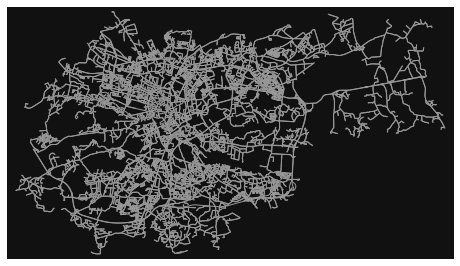

In [2]:
G = ox.load_graphml('data/Krakow.graphml')
fig, ax = ox.plot_graph(G, node_size=0)

<h3>Load area, replacing 'name.shp' with the actual name of your shapefile</h3>

<Axes: >

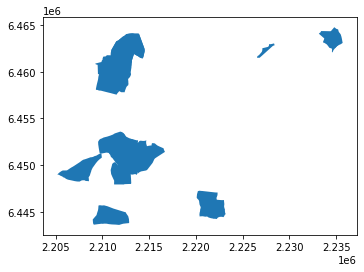

In [3]:
# Replace 'name.shp' with the actual name of your shapefile
shapefile_path = 'data/areas_SUM_old.shp'

# Read the shapefile
gdf_areas = gpd.read_file(shapefile_path)
gdf_areas.plot()

centroid_x:  2211988.556678999 centroid_y:  6461693.803223036


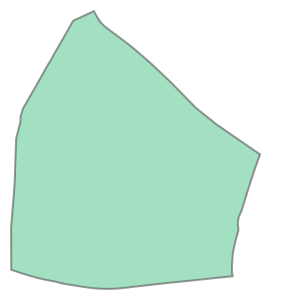

In [4]:
# get centroids for the specified polygon
polygon = gdf_areas.geometry[8]
x, y = polygon.centroid.x, polygon.centroid.y
print("centroid_x: ", x, "centroid_y: ", y)
polygon

In [5]:
# transform coordinates from the source coordinate system to the target
x_center, y_center = fncs.transform_coords("EPSG:3857", "EPSG:4326", x, y)

<h3>Load city zones</h3>

total number of zones is  396


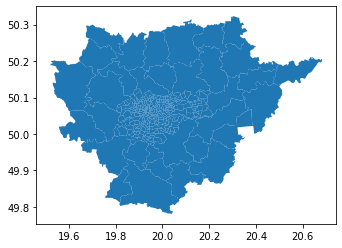

In [6]:
shapefile_path = 'data/krk.geojson'
gdf_zones = gpd.read_file(shapefile_path)

geometries = gdf_zones['geometry']
gdf_zones.plot()
print('total number of zones is ', len(gdf_zones))

<h3>Load address points (population)</h3>

In [7]:
df = pd.read_csv('data/krk_demographic.csv')
df = df.rename(columns={"adr_pelny": "address", "ogolem": "total" })
df.head(3)

,FID,x,y,address,total
0,0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975
1,1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955
2,2,19.997005,50.085446,STANISŁAWA SKARŻYŃSKIEGO 5,832


In [8]:
# assign zone number to each address point
df['zone_NO'] = df.apply(lambda row: fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
df.head(3)

,FID,x,y,address,total,zone_NO
0,0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975,147.0
1,1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955,234.0
2,2,19.997005,50.085446,STANISŁAWA SKARŻYŃSKIEGO 5,832,147.0


In [9]:
# remove the trips with nan zone
df.dropna(subset='zone_NO', inplace=True, ignore_index=True)
df

,FID,x,y,address,total,zone_NO
0,0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975,147.0
1,1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955,234.0
2,2,19.997005,50.085446,STANISŁAWA SKARŻYŃSKIEGO 5,832,147.0
3,3,20.021469,50.086969,OSIEDLE KAZIMIERZOWSKIE 29,785,239.0
4,4,19.996731,50.084792,STANISŁAWA SKARŻYŃSKIEGO 3,775,147.0
...,...,...,...,...,...,...
47704,47705,19.978465,50.072244,OSTATNIA 27,1,145.0
47705,47706,19.954666,50.057313,KAROLA CHODKIEWICZA 10C,1,53.0
47706,47707,19.879556,50.085813,WŁODZIMIERZA TETMAJERA 17A,1,202.0
47707,47708,20.008240,50.071772,POLESKA 12A,1,264.0


<h3>Load OD matrix</h3>

In [10]:
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT')
od.head(3)

,464 x 464,Unnamed: 1,Unnamed: 2,1,2,3,4,5,6,7,...,111142,111143,111144,111145,111146,111147,111148,111149,111150,111151
0,NaN,Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DP (Hucisko) - Metropolia,DW966 (Łazany) - Metropolia,DK94 (Czyżów) - Metropolia,A4 (Niepołomice) - Metropolia,DK75 (Niepołomice) - Metropolia,DW964 (Ispina) - Metropolia,DK79 (Nowe Brzesko) - Metropolia,DW964 (Posądza) - Metropolia,DP (Łoskowice) - Metropolia,DP (Polanowice) - Metropolia
1,NaN,NaN,Sum,2015.498655,690.500438,133.437003,233.015785,372.647176,985.102155,694.674881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,1.0,NaN,310.354222,19.207737,5.618076,1.358516,1.865533,3.194659,7.530912,6.768101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# clean the data
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop([0, 1], inplace=True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
print(od.shape)
od.head(3)

(460, 466)


,zone_NO,sum,1,2,3,4,5,6,7,8,...,111142,111143,111144,111145,111146,111147,111148,111149,111150,111151
0,5,120.849949,7.238414,2.946652,0.763309,1.607510,2.034931,3.760960,3.415068,0.854213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,220.551037,11.830538,3.900192,0.921459,2.205918,2.586233,8.553715,6.075817,2.149067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,169.820342,11.265707,3.656050,0.923361,1.472460,2.453034,6.450564,4.834514,2.096643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# filter OD zone number to match city zones
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od

,zone_NO,sum,1,2,3,4,5,6,7,8,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,5,120.849949,7.238414,2.946652,0.763309,1.607510,2.034931,3.760960,3.415068,0.854213,...,0.0,0.394573,0.0,0.0,0.0,0.041474,0.272758,0.083795,0.389589,0.069292
1,6,220.551037,11.830538,3.900192,0.921459,2.205918,2.586233,8.553715,6.075817,2.149067,...,0.0,0.688432,0.0,0.0,0.0,0.07234,0.476948,0.144481,0.66802,0.114119
2,7,169.820342,11.265707,3.656050,0.923361,1.472460,2.453034,6.450564,4.834514,2.096643,...,0.0,0.601062,0.0,0.0,0.0,0.062572,0.41248,0.126186,0.586275,0.098878
3,8,208.07807,11.589887,3.301125,0.756318,1.422284,2.196464,7.624830,5.095894,3.564942,...,0.0,0.70812,0.0,0.0,0.0,0.073847,0.487958,0.149041,0.691977,0.117124
4,9,71.533134,3.690724,1.088827,0.255724,0.457842,0.722417,2.374762,1.673481,0.859118,...,0.0,0.37581,0.0,0.0,0.0,0.037855,0.2502,0.078549,0.369976,0.057531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1029,282.275654,9.583254,3.286420,0.527635,0.735480,1.774332,4.864994,3.367301,1.120050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0421
388,1030,1702.178747,56.139723,19.231162,3.058852,4.204538,10.367208,28.630317,19.783654,6.543279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1809,0.0
389,1031,346.517783,11.745645,4.023299,0.639822,0.884477,2.177251,5.979931,4.132085,1.364776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5491,0.1346
390,1032,765.700482,25.930052,8.897446,1.395392,1.892363,4.816125,13.220900,9.122293,2.978852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1175,4.1399,0.0,0.0


In [16]:
# calculate probabilities for each origin point
od_probs = od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)
od_probs.insert(0, 'zone_NO', od['zone_NO'])
od_probs.head(3)

,zone_NO,sum,1,2,3,4,5,6,7,8,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,5,1.0,0.059896,0.024383,0.006316,0.013302,0.016838,0.031121,0.028259,0.007068,...,0.0,0.003265,0.0,0.0,0.0,0.000343,0.002257,0.000693,0.003224,0.000573
1,6,1.0,0.053641,0.017684,0.004178,0.010002,0.011726,0.038783,0.027548,0.009744,...,0.0,0.003121,0.0,0.0,0.0,0.000328,0.002163,0.000655,0.003029,0.000517
2,7,1.0,0.066339,0.021529,0.005437,0.008671,0.014445,0.037985,0.028468,0.012346,...,0.0,0.003539,0.0,0.0,0.0,0.000368,0.002429,0.000743,0.003452,0.000582


In [17]:
# filter trips origin based on a specific polygon (SUM area)
xs, ys = polygon.exterior.xy[0], polygon.exterior.xy[1] # lists with polygon exterior coords
xs, ys = fncs.transform_coords("EPSG:3857", "EPSG:4326", xs, ys)
poly = Polygon(zip(xs, ys))

In [19]:
# check, if SUM area containes address points
df['inside_poly'] = df.apply(lambda row: poly.contains(Point(row['x'], row['y'])), axis=1)
df.tail()

,FID,x,y,address,total,zone_NO,inside_poly
47704,47705,19.978465,50.072244,OSTATNIA 27,1,145.0,False
47705,47706,19.954666,50.057313,KAROLA CHODKIEWICZA 10C,1,53.0,False
47706,47707,19.879556,50.085813,WŁODZIMIERZA TETMAJERA 17A,1,202.0,True
47707,47708,20.008240,50.071772,POLESKA 12A,1,264.0,False
47708,47709,19.947082,49.988173,LECZNICZA 17C,1,306.0,False


<h3>For preselected SUM area</h3>

In [20]:
# filter addresses belonging to SUM area
df = df[df.inside_poly == True] # demographic of the ith SUM area
df.head(3)

,FID,x,y,address,total,zone_NO,inside_poly
3851,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True
4426,4426,19.880144,50.084124,GEN. BOLESŁAWA WIENIAWY-DŁUGOSZOWSKIEGO 10,39,202.0,True
5474,5474,19.877861,50.084325,OSIEDLE ZŁOTA PODKOWA 34,28,202.0,True


In [21]:
# TODO: EDIT using sample(trips_i) - from ODM
# repeat Rows N times (equal "ogolem / total"): N Rows = N people     EDIT!!!
df = df.loc[df.index.repeat(df.total)].reset_index(drop=True) 
df.head(3)

,FID,x,y,address,total,zone_NO,inside_poly
0,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True
1,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True
2,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True


In [23]:
# TODO: EDIT !!!
# assign probabilities to specified zone
df['probs'] = [[]] * len(df)
df['desti_zones'] = [[]] * len(df)

for i in range(len(df)):
    z = int(df.iloc[i].zone_NO) # zone number
    row = od_probs.loc[od_probs['zone_NO'] == z].iloc[0]
    row = row[2:]
    df.at[i, 'desti_zones'] = list(row.index)
    df.at[i, 'probs'] =list(row)
    dic = row.to_dict()
    df.at[i, 'prob_dict'] = [dic]
print(df.shape)
df.head(3)

(1836, 10)


,FID,x,y,address,total,zone_NO,inside_poly,probs,desti_zones,prob_dict
0,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031..."
1,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031..."
2,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031..."


In [24]:
# assign destination zone number based on probabilities
df['desti_zone'] = df.apply(lambda row: random.choices(row.desti_zones, weights=row.probs, k=1)[0], axis=1)
df.head(3)

,FID,x,y,address,total,zone_NO,inside_poly,probs,desti_zones,prob_dict,desti_zone
0,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031...",3
1,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031...",204
2,3851,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,202.0,True,"[0.02432638455733144, 0.007647776978031019, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[{1: 0.02432638455733144, 2: 0.007647776978031...",31


<h3>Load city zone centroids</h3>

<Axes: >

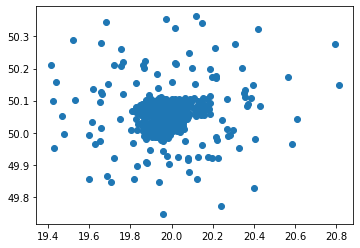

In [25]:
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')
gdf_centroid.plot()

In [26]:
# assign centroid coordinates for the destination zone
df['desti_x'] = df.apply(lambda row: 
                               gdf_centroid[gdf_centroid.NO == row.desti_zone].geometry.iloc[0].coords.xy[0][0], axis=1)
df['desti_y'] = df.apply(lambda row: 
                               gdf_centroid[gdf_centroid.NO == row.desti_zone].geometry.iloc[0].coords.xy[1][0], axis=1)

In [ ]:
# save to output folder
df.to_csv('output/demand_area8.csv', index=False)

In [ ]:
df_demand = pd.read_csv('output/demand_area8.csv')
# df_demand.drop('Unnamed: 0', inplace=True, axis=1)
df_demand

In [ ]:
df_demand['treq'] = pd.NA # generate the request time
time_format = '%Y-%m-%d %H:%M:%S'
time_lb = dt.datetime.strptime('2024-03-28 07:45:00', time_format)
time_ub = dt.datetime.strptime('2024-03-28 08:15:00', time_format)
df_demand['treq'] = df_demand['treq'].apply(lambda _: time_lb + dt.timedelta(seconds=np.random.randint(0, (time_ub - time_lb).seconds)))
df_demand

In [ ]:
df.to_csv('data/georequests_O(area12)_D.csv', index=False)